Optimisation de l'entrainement pour `focus` 
This is the same function as used in `10_Transfer_learning_what_networks.ipynb`
> ... TODO ... # TODO test without circular padding, with Adam, with no warmstart 

    model = torchvision.models.resnet18(weights=None)

# optimize meta-parameters

In [1]:
import dataclasses

In [2]:
# print_gpu_memory()

# print(path_save)
# %ls -l {path}*

%rm "cached_data/34_optuna.sqlite3"  # FORCING RECOMPUTE

rm: cached_data/34_optuna.sqlite3: No such file or directory


In [3]:
import warnings
from optuna.exceptions import ExperimentalWarning
warnings.filterwarnings("ignore", category=ExperimentalWarning,
    # module=r"optuna\._experimental"
)

In [4]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [5]:
import retinoto_py as fovea
dataset = 'focus'
batch_size = 64
args = fovea.Params()
opts_dict = dict(do_fovea=True, subset_factor=25, num_epochs=1, verbose=False)
args = dataclasses.replace(args, **opts_dict)
args

Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	- Timestamp (UTC)  2025-12-05_08-08-01	 user laurentperrinet	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 2018 has been set.


Params(image_size=224, do_mask=False, do_fovea=True, rs_min=0.0, rs_max=-6.0, padding_mode='zeros', seed=2018, batch_size=80, num_workers=1, in_memory=False, model_name='convnext_base', num_epochs=1, subset_factor=25, lr=1e-06, delta1=0.1, delta2=0.007, weight_decay=0.03, label_smoothing=0.2, shuffle=True, verbose=False)

In [6]:
model_filename = None # do not use resumed net
model_filename = args.data_cache / f'32_fovea_model_name={args.model_name}_dataset={dataset}.pth'


In [7]:
TRAIN_DATA_DIR = args.DATAROOT / f'Imagenet_{dataset}' / 'train'
train_dataset = fovea.get_dataset(args, TRAIN_DATA_DIR)
train_loader = fovea.get_loader(args, train_dataset)
VAL_DATA_DIR = args.DATAROOT / f'Imagenet_{dataset}' / 'val'
val_dataset = fovea.get_dataset(args, VAL_DATA_DIR)
val_loader = fovea.get_loader(args, val_dataset)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/laurentperrinet/data/Imagenet/Imagenet_focus/train'

In [8]:
def objective(trial):
    args = fovea.Params()
    args = dataclasses.replace(args, **opts_dict)
    model = fovea.load_model(args, model_filename=model_filename)

    # # args.batch_size = trial.suggest_int('batch_size', 16, 512, log=True, step=1)
    # # args.rs_min = trial.suggest_float('rs_min', -1, 1.)
    # # args.rs_max = trial.suggest_float('rs_max', -7, -4)
    scale = 10
    # if args.delta2>0: args.delta2 = trial.suggest_float('delta2', 0.001, 0.9, log=True)
    args.lr = trial.suggest_float('lr', args.lr / scale, args.lr * scale, log=True)

    args.delta1 = trial.suggest_float('delta1', args.delta1 / scale, min((args.delta1 * scale, 1)), log=True)
    # weight_decay = 0.005 if opt.weight_decay==0 else opt.weight_decay
    # args.weight_decay = trial.suggest_float('weight_decay', args.weight_decay / scale, min((args.weight_decay * scale, 1)), log=True)
    args.weight_decay = trial.suggest_float('weight_decay', args.weight_decay / scale, args.weight_decay * scale, log=True)

    scale = 100 
    # label_smoothing = 0.005 if opt.label_smoothing==0 else opt.label_smoothing
    # args.label_smoothing = trial.suggest_float('label_smoothing', label_smoothing / scale, label_smoothing * scale, log=True)

    # args.im_mean = trial.suggest_float('im_mean', opt.im_mean / scale, opt.im_mean * scale, log=True)
    # args.im_std = trial.suggest_float('im_std', opt.im_std / scale, opt.im_std * scale, log=True)


    # get the architecture of the network, train and get accuracy on the validation set
    _, df_train = fovea.train_model(args, model=model, train_loader=train_loader, val_loader=val_loader)
    accuracy = df_train['acc_val'].mean()
    
    return accuracy
    
# 3. Create a study object and optimize the objective function.
study = optuna.create_study(storage=f"sqlite:///cached_data/34_optuna.sqlite3", 
                            sampler=optuna.samplers.TPESampler(multivariate=False, warn_independent_sampling=False),
                            direction='maximize', load_if_exists=True, study_name=f"34_optuna")
print(f'Starting optimization with params: {args} on {max(150-len(study.trials), 0)} trials - {len(study.trials)} ')
study.optimize(objective, n_trials=max((150-len(study.trials), 0)), n_jobs=1, show_progress_bar=True)

print(50*'-.')
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
print("Best Trial: ", study.best_trial)
# print("Trials: ", study.trials)

Starting optimization with params: Params(image_size=224, do_mask=False, do_fovea=True, rs_min=0.0, rs_max=-6.0, padding_mode='zeros', seed=2018, batch_size=80, num_workers=1, in_memory=False, model_name='convnext_base', num_epochs=1, subset_factor=25, lr=1e-06, delta1=0.1, delta2=0.007, weight_decay=0.03, label_smoothing=0.2, shuffle=True, verbose=False) on 150 trials - 0 


  0%|          | 0/150 [00:00<?, ?it/s]

[W 2025-12-05 09:08:03,125] Trial 0 failed with parameters: {} because of the following error: FileNotFoundError(2, 'No such file or directory').
Traceback (most recent call last):
  File "/Users/laurentperrinet/app54-nextcloud/science/retinoto_py/.venv/lib/python3.13/site-packages/optuna/study/_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/3s/q2x8bxzj43g4rdvb2wjt67640000gq/T/ipykernel_30149/276707811.py", line 4, in objective
    model = fovea.load_model(args, model_filename=model_filename)
  File "/Users/laurentperrinet/app54-nextcloud/science/retinoto_py/src/retinoto_py/torch_utils.py", line 358, in load_model
    model = apply_weights(model, model_filename, args.device, verbose=args.verbose)
  File "/Users/laurentperrinet/app54-nextcloud/science/retinoto_py/src/retinoto_py/torch_utils.py", line 373, in apply_weights
    model.load_state_dict(torch.load(model_filename, map_location=torch.device(device)))
                          ~~~~~~

FileNotFoundError: [Errno 2] No such file or directory: 'cached_data/32_fovea_model_name=convnext_base_dataset=focus.pth'

In [9]:
import optuna.visualization.matplotlib as vis

[W 2025-12-05 09:08:04,100] Study instance does not contain completed trials.


/Users/laurentperrinet/app54-nextcloud/science/retinoto_py/.venv/lib/python3.13/site-packages/optuna/visualization/matplotlib/_param_importances.py:111: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="best")


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

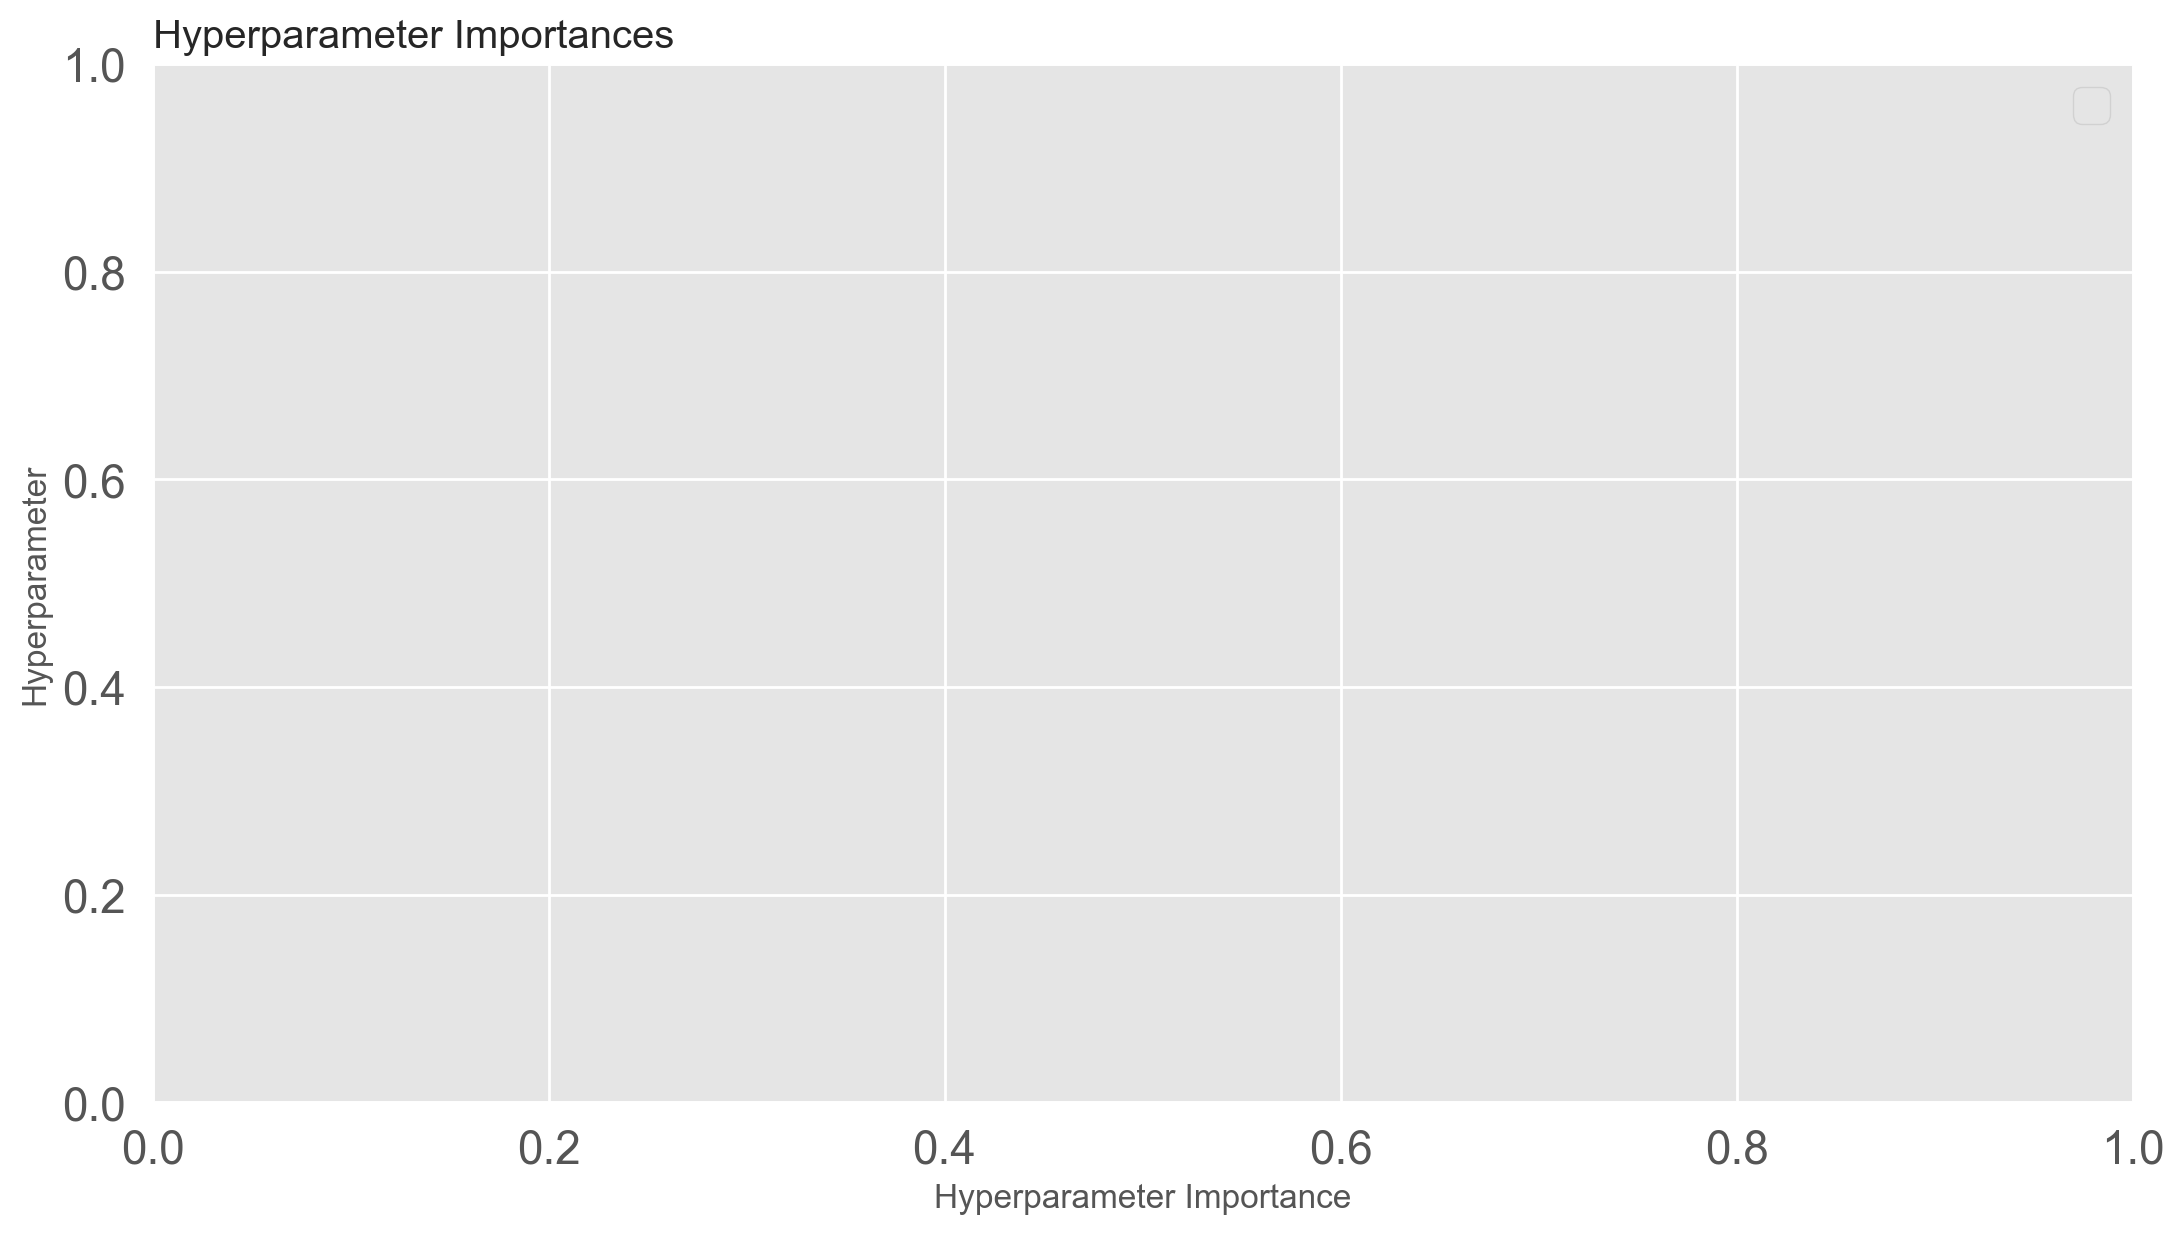

In [10]:
vis.plot_param_importances(study)

In [11]:
# df = study.trials_dataframe()   
params = sorted({k for t in study.trials for k in t.params})
params

[]

In [12]:
fig, axes = fovea.plt.subplots(len(params), 1, figsize=(15, 8*len(params)), sharey=True)

for ax, pname in zip(axes, params):
    xs = [t.params[pname] for t in study.trials if pname in t.params]
    ys = [t.value for t in study.trials if pname in t.params]
    ax.scatter(xs, ys, s=20, alpha=0.6)
    ax.set_xlabel(pname)
    ax.set_ylabel("Objective")

fovea.plt.tight_layout()

ValueError: Number of rows must be a positive integer, not 0

<Figure size 3000x0 with 0 Axes>